In [1]:
import hopsworks
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os

/u/11/zhangz13/unix/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
api = 'HeCatNGJxisb99Vf.ircWdTrkgbbZpBMU7iPN2zqDIwoTuaSX88LPeISIMJHuzP3icXixNd6JFcWUqakL'
project = hopsworks.login(api_key_value = api)
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/229529
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
wine_fg = fs.get_feature_group(name="wine_2", version=1)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine_2",
                                  version=1,
                                  description="Read from Wine Quality dataset",
                                  labels=["quality"],
                                  query=query)

In [4]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)        
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)
print("length of x X_train:",X_train.shape)
print("length of x X_test:",X_test.shape)
from sklearn.linear_model import LogisticRegression
# Train our model with the Scikit-learn K-nearest-neighbors algorithm using our features (X_train) and labels (y_train)
model = LogisticRegression(random_state = 0, penalty = 'l2',max_iter=15000 )
model.fit(X_train, y_train.values.ravel())

Finished: Reading data from Hopsworks, using Hive (3.09s) 


length of x X_train: (4264, 12)
length of x X_test: (1066, 12)


LogisticRegression(max_iter=15000, random_state=0)

In [5]:
X_train

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,type_white
0,8.200000,0.370000,0.360,1.000000,0.034000,17.000000,93.000000,0.99060,3.040000,0.320000,11.700000,1
1,6.700000,0.120000,0.360,2.300000,0.039000,43.000000,125.000000,0.99229,3.070000,0.670000,10.100000,1
2,10.700000,0.520000,0.380,2.600000,0.066000,29.000000,56.000000,0.99577,3.150000,0.790000,12.100000,0
3,8.400000,0.190000,0.430,2.100000,0.052000,20.000000,104.000000,0.99400,2.850000,0.460000,9.500000,1
4,7.500000,0.705000,0.240,1.800000,0.360000,15.000000,63.000000,0.99640,3.000000,1.590000,9.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5324,8.400000,0.170000,0.310,6.700000,0.038000,29.000000,132.000000,0.99450,3.100000,0.320000,10.600000,1
5326,5.400000,0.290000,0.380,1.200000,0.029000,31.000000,132.000000,0.98895,3.280000,0.360000,12.400000,1
5327,6.400000,0.180000,0.350,1.000000,0.045000,39.000000,108.000000,0.99110,3.310000,0.350000,10.900000,1
5328,6.100000,0.340000,0.270,2.600000,0.024000,20.000000,105.000000,0.99060,3.400000,0.670000,12.200000,1


In [6]:
y_train.value_counts()

quality
0          3436
1           822
2             6
Name: count, dtype: int64

In [7]:
y_test.value_counts()

quality
0          882
1          184
Name: count, dtype: int64

In [8]:
y_pred = model.predict(X_test)
y_pred.min()

0

In [9]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state = 0, n_estimators = 150,
                                    criterion = 'entropy')
y_train_1d = y_train.values.ravel() if isinstance(y_train, pd.DataFrame) else y_train.ravel()
y_test_1d = y_test.values.ravel() if isinstance(y_test, pd.DataFrame) else y_test.ravel()

classifier.fit(X_train, y_train)

# Predicting Test Set
y_pred = classifier.predict(X_test)
print("y_pred max is:",y_train.max())
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred,average='weighted')
rec = recall_score(y_test, y_pred,average='weighted')
f1 = f1_score(y_test, y_pred,average='weighted')

model_results = pd.DataFrame([['Random Forest (n=100)', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])


print(model_results)

y_pred max is: quality    2
dtype: int64
                   Model  Accuracy  Precision    Recall  F1 Score
0  Random Forest (n=100)  0.861163   0.845733  0.861163  0.845963


In [10]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
acc = accuracy_score(y_test, y_pred)
print(acc)

0.8442776735459663


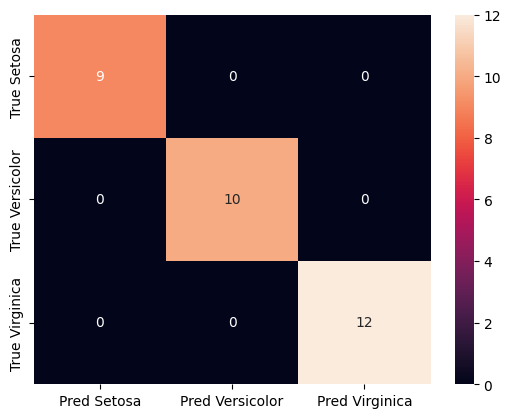

In [9]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
# df_cm = pd.DataFrame(results, ['True Setosa', 'True Versicolor', 'True Virginica'],
#                      ['Pred Setosa', 'Pred Versicolor', 'Pred Virginica'])
# cm = sns.heatmap(df_cm, annot=True)
# fig = cm.get_figure()

In [12]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model_2"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model_2.pkl")
# fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)
# Ensure that the metrics are single numerical values
wine_model = mr.python.create_model(
    name="wine_model_2", 
    metrics={
        "accuracy": model_results['Accuracy'].iloc[0],
        "Precision": model_results['Precision'].iloc[0],
        "Recall": model_results['Recall'].iloc[0],
        "F1_score": model_results['F1 Score'].iloc[0]
    },
    model_schema=model_schema,
    description="Wine Quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)


Connected. Call `.close()` to terminate connection gracefully.


Uploading: 100.000%|██████████| 1695/1695 elapsed<00:01 remaining<00:00:01,  3.25it/s]
Uploading: 100.000%|██████████| 1072/1072 elapsed<00:01 remaining<00:000:04,  1.16s/it]
Model export complete: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/229529/models/wine_model/1


Model(name: 'wine_model', version: 1)